<a href="https://colab.research.google.com/github/gustavoalcantara/dissertacao/blob/main/cox_model_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
install.packages('data.table')
install.packages('survminer')
install.packages('survival')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘litedown’, ‘corrplot’, ‘car’, ‘markdown’, ‘jpeg’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘exactRankTests’, ‘mvtnorm’, ‘KMsurv’, ‘zoo’, ‘km.ci’, ‘gridtext’, ‘ggpubr’, ‘gridExtra’, ‘maxstat’, ‘survMisc’, ‘ggtext’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [22]:
#library(data.table)
library(survminer)
library(survival)
library(tidyverse)

In [17]:
x <- data.table::fread('srag_covid.csv', sep = ',', header = T)

In [19]:
x|>
  dplyr::filter(classificacao_final == 5 &
                  pcr_sarscov2 == 1 &
                  puerpera  %in% c(2, 9, NA),
                gestante %in% c(5, 6, 9, NA),
                !sexo == 'I',
                ano %in% c(2020, 2021, 2022)) -> x

#ETL que muda/cria/renomeia e condiciona variávies
x|>
  dplyr:: mutate(
    idade = as.numeric(difftime(Sys.Date(), data_nascimento, units = "days")) %/% 365,
    faixa_etaria = dplyr::case_when(
      idade >= 0 & idade <= 4 ~ '0-4',
      idade >= 5 & idade <= 9 ~ '5-9',
      idade >= 10 & idade <= 14 ~ '10-14',
      idade >= 15 & idade <= 19 ~ '15-19',
      idade >= 20 & idade <= 24 ~ '20-24',
      idade >= 25 & idade <= 29 ~ '25-29',
      idade >= 30 & idade <= 34 ~ '30-34',
      idade >= 35 & idade <= 39 ~ '35-39',
      idade >= 40 & idade <= 44 ~ '40-44',
      idade >= 45 & idade <= 49 ~ '45-49',
      idade >= 50 & idade <= 54 ~ '50-54',
      idade >= 55 & idade <= 59 ~ '55-59',
      idade >= 60 & idade <= 64 ~ '60-64',
      idade >= 65 & idade <= 69 ~ '65-69',
      idade >= 70 & idade <= 74 ~ '70-74',
      idade >= 75 & idade <= 79 ~ '75-79',
      idade >= 80 ~ '80+'
    ),
    faixa_etaria_dez = dplyr::case_when(
        idade >= 0   & idade <= 9   ~ '0-9',
        idade >= 10  & idade <= 19  ~ '10-19',
        idade >= 20  & idade <= 29  ~ '20-29',
        idade >= 30  & idade <= 39  ~ '30-39',
        idade >= 40  & idade <= 49  ~ '40-49',
        idade >= 50  & idade <= 59  ~ '50-59',
        idade >= 60  & idade <= 69  ~ '60-69',
        idade >= 70  & idade <= 79  ~ '70-79',
        idade >= 80               ~ '80+',
        TRUE                      ~ 'Sem informação'
    ),
    raca_cor = dplyr::case_when(
      raca_cor == 1 ~ 'Branca',
      raca_cor == 2 ~ 'Preta',
      raca_cor == 3 ~ 'Amarela',
      raca_cor == 4 ~ 'Parda',
      raca_cor == 5 ~ 'Indígena',
      TRUE ~ 'Sem informação'
    ),
    escolaridade = dplyr::case_when(
      escolaridade == 0 ~ 'Sem Escolaridade',
      escolaridade == 1 ~ 'Fundamental 1º Ciclo',
      escolaridade == 2 ~ 'Fundamental 2º Ciclo',
      escolaridade == 3 ~ 'Médio',
      escolaridade == 4 ~ 'Superior',
      TRUE ~ 'Sem informação'
      ),
    possui_cardiopatia = dplyr::case_when(
      possui_cardiopatia == 1 ~ 'Sim',
      possui_cardiopatia == 2 ~ 'Não',
      TRUE ~ 'Sem informação'
    ),
    possui_pneumopatia = dplyr::case_when(
      possui_pneumopatia == 1 ~ 'Sim',
      possui_pneumopatia == 2 ~ 'Não',
      TRUE ~ 'Sem informação'
    ),
    possui_doenca_renal = dplyr::case_when(
      possui_doenca_renal == 1 ~ 'Sim',
      possui_doenca_renal == 2 ~ 'Não',
      TRUE ~ 'Sem informação'
    ),
    possui_doenca_neurologica = dplyr::case_when(
      possui_doenca_neurologica == 1 ~ 'Sim',
      possui_doenca_neurologica == 2 ~ 'Não',
      TRUE ~ 'Sem informação'
    ),
    possui_obesidade = dplyr::case_when(
      possui_obesidade == 1 ~ 'Sim',
      possui_obesidade == 2 ~ 'Não',
      TRUE ~ 'Sem informação'
    ),
    possui_asma = dplyr::case_when(
      possui_asma == 1 ~ 'Sim',
      possui_asma == 2 ~ 'Não',
      TRUE ~ 'Sem informação'
    ),
    tempo_ate_internacao = as.numeric(difftime(data_internacao, data_primeiros_sintomas, units = "days")),
    regiao =  dplyr::case_when(
      sigla_uf_internacao %in% c("AC", "AP", "AM", "PA", "RO", "RR", "TO") ~ "Norte",
      sigla_uf_internacao %in% c("AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE") ~ "Nordeste",
      sigla_uf_internacao %in% c("DF", "GO", "MT", "MS") ~ "Centro-Oeste",
      sigla_uf_internacao %in% c("ES", "MG", "RJ", "SP") ~ "Sudeste",
      sigla_uf_internacao %in% c("PR", "RS", "SC") ~ "Sul",
      TRUE ~ NA_character_
    ),
    evolucao_caso = dplyr::case_when(
      evolucao_caso == 1 ~ 'Cura',
      evolucao_caso == 2 ~ 'Óbito',
      evolucao_caso == 3 ~ 'Óbito por outras causas',
      TRUE ~ NA_character_
    ),
    faixa_etaria_dez = factor(
      faixa_etaria_dez,
      levels = c("0-9", "10-19", "20-29", "30-39", "40-49",
                 "50-59", "60-69", "70-79", "80+")
    ),
    faixa_etaria = factor(
      faixa_etaria,
      levels = c("0-4", "5-9", "10-14", "15-19", "20-24", "25-29",
                 "30-34", "35-39", "40-44", "45-49", "50-54",
                 "55-59", "60-64", "65-69", "70-74", "75-79", "80+")
    )) -> x

#Criação de Variáveis de tempo
x |>
  dplyr::mutate(tempo_ate_obito =
                  as.numeric(difftime(data_alta_obito, data_primeiros_sintomas,
                                      units = 'days')),
                tempo_ate_obito_internacao =
                  as.numeric(difftime(data_alta_obito, data_internacao,
                                      units = 'days')),
                sexo = dplyr::recode(sexo, "F" = "Feminino", "M" = "Masculino")) -> x

#Cria Variável de Status para usar no Kaplan-Meier
x|>
  dplyr::mutate(status =
                  dplyr::case_when(evolucao_caso == 'Óbito' ~ 1,
                                   evolucao_caso == 'Cura' ~ 0)) -> x

In [23]:
x|>
  dplyr::filter(tempo_ate_obito>=0 &
                  tempo_ate_obito <= 60) ->x

In [24]:
y<-Surv(x$tempo_ate_obito, x$status)

In [25]:
#raca_cor
x$raca_cor <- relevel(as.factor(x$raca_cor), ref = "Branca")
raca_cor<-coxph(y~raca_cor, data=x, x=TRUE)

#Sexo
x$sexo <- relevel(as.factor(x$sexo), ref = 'Feminino')
sexo <- coxph(y~sexo, data=x, x=TRUE)

#Região
x$regiao <- relevel(as.factor(x$regiao), ref = 'Centro-Oeste')
regiao <- coxph(y~regiao, data=x, x=TRUE)

#Ensino
x$escolaridade <- relevel(as.factor(x$escolaridade), ref = 'Superior')
escolaridade <- coxph(y~escolaridade, data=x, x=TRUE)

#Faixas Etárias
x <- x|>
  dplyr::mutate(faixa_etaria_ibge =
                  dplyr::case_when(
                    idade <= 14 ~ 'Infância',
                    idade <= 29 ~ 'Jovem',
                    idade <= 59 ~ 'Adulto',
                    idade >= 60 ~ 'Idoso',
                    TRUE ~ 'Sem informação'))

x$faixa_etaria_ibge <- relevel(as.factor(x$faixa_etaria_ibge), ref = 'Infância')
faixa_etaria <- coxph(y~faixa_etaria_ibge, data=x, x=TRUE)

#Cardiopatia
x$possui_cardiopatia <- relevel(as.factor(x$possui_cardiopatia), ref = 'Não')
cardiopatia <- coxph(y~possui_cardiopatia, data=x, x=TRUE)

#Pneumopatia
x$possui_pneumopatia <- relevel(as.factor(x$possui_pneumopatia), ref = 'Não')
pneumopatia <- coxph(y~possui_pneumopatia, data=x, x=TRUE)

#Doença Renal
x$possui_doenca_renal <- relevel(as.factor(x$possui_doenca_renal), ref = 'Não')
doenca_renal <- coxph(y~possui_doenca_renal, data=x, x=TRUE)

#Doença Neurológica
x$possui_doenca_neurologica <- relevel(as.factor(x$possui_doenca_neurologica), ref = 'Não')
doenca_neurologica <- coxph(y~possui_doenca_neurologica, data=x, x=TRUE)

#Obesidade
x$possui_obesidade <- relevel(as.factor(x$possui_obesidade), ref = 'Não')
obesidade <- coxph(y~possui_obesidade, data=x, x=TRUE)

#Asma
x$possui_asma <- relevel(as.factor(x$possui_asma), ref = 'Não')
asma <- coxph(y~possui_asma, data=x, x=TRUE)

#Modelo final
modelo_final <- coxph(y~faixa_etaria_ibge+
                        escolaridade +
                        regiao +
                        raca_cor +
                        sexo +
                        possui_cardiopatia +
                        possui_pneumopatia +
                        possui_doenca_renal +
                        possui_doenca_neurologica +
                        possui_obesidade +
                        possui_asma,
                      data = x)

In [26]:
teste_ph <- cox.zph(modelo_final)

In [28]:
print(teste_ph)

                          chisq df      p
faixa_etaria_ibge          3631  4 <2e-16
escolaridade               2730  5 <2e-16
regiao                     1922  4 <2e-16
raca_cor                    762  5 <2e-16
sexo                        430  1 <2e-16
possui_cardiopatia          268  2 <2e-16
possui_pneumopatia          320  2 <2e-16
possui_doenca_renal         614  2 <2e-16
possui_doenca_neurologica  1285  2 <2e-16
possui_obesidade            167  2 <2e-16
possui_asma                 103  2 <2e-16
GLOBAL                     9374 31 <2e-16


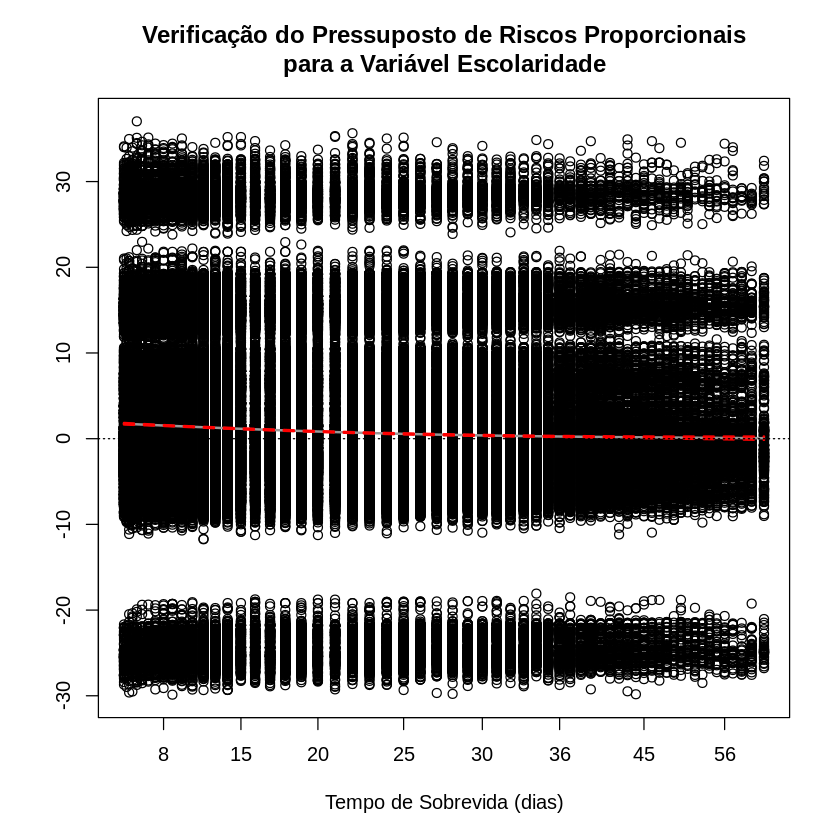

In [30]:
# Exemplo com mais customizações para um visual mais limpo
plot(teste_ph,
     var = "escolaridade",
     col = c("gray60", "red", "black"),  # Pontos em cinza para não poluir, linha vermelha
     lwd = 2,                           # Deixa a linha central mais grossa (espessura 2)
     pch = 1,                           # Bolinhas vazadas para os pontos
     xlab = "Tempo de Sobrevida (dias)",
     ylab = "Resíduo de Schoenfeld (β(t)) para Escolaridade",
     main = "Verificação do Pressuposto de Riscos Proporcionais\npara a Variável Escolaridade"
)

# Adiciona uma linha de referência no zero, se quiser
abline(h = 0, lty = 3, col = "black")

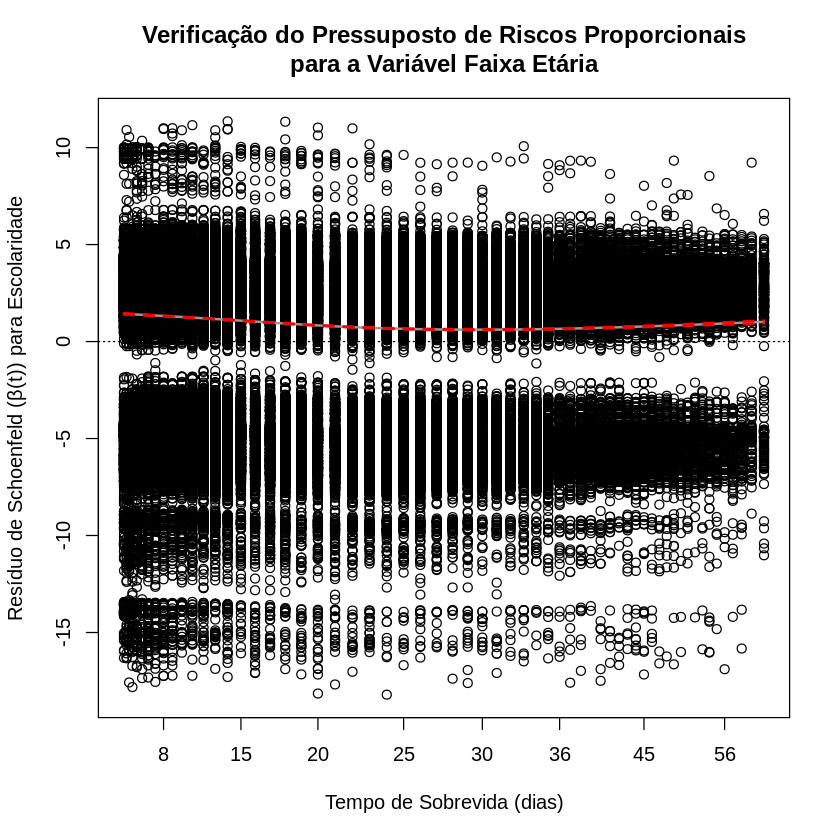

In [33]:
# Exemplo com mais customizações para um visual mais limpo
plot(teste_ph,
     var = "faixa_etaria_ibge",
     col = c("gray60", "red", "black"),  # Pontos em cinza para não poluir, linha vermelha
     lwd = 2,                           # Deixa a linha central mais grossa (espessura 2)
     pch = 1,                           # Bolinhas vazadas para os pontos
     xlab = "Tempo de Sobrevida (dias)",
     ylab = "Resíduo de Schoenfeld (β(t)) para Escolaridade",
     main = "Verificação do Pressuposto de Riscos Proporcionais\npara a Variável Faixa Etária"
)

# Adiciona uma linha de referência no zero, se quiser
abline(h = 0, lty = 3, col = "black")

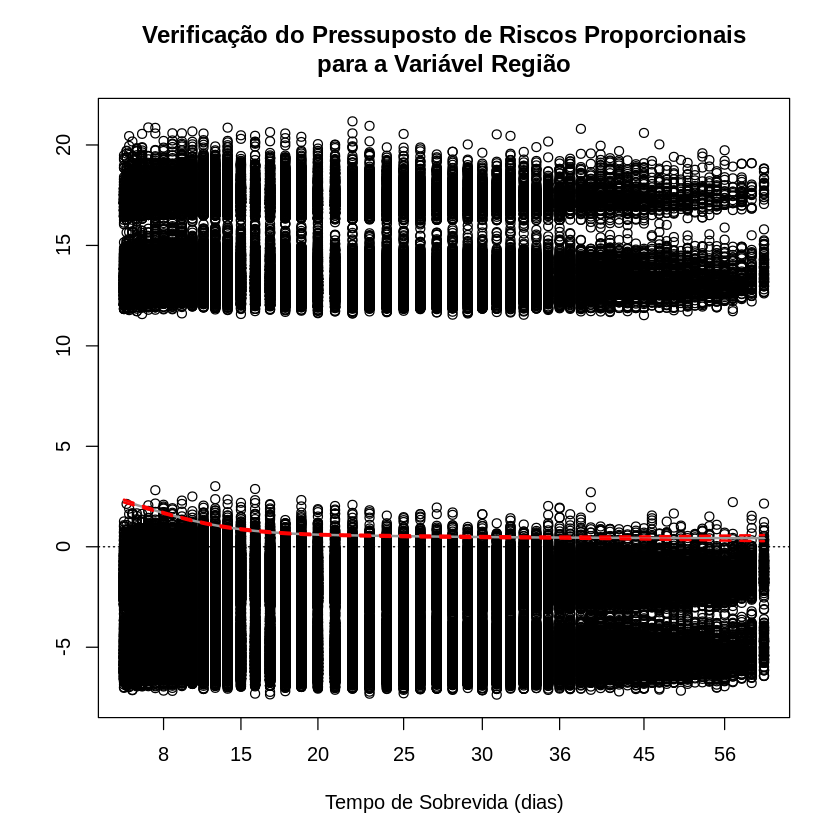

In [37]:
# Exemplo com mais customizações para um visual mais limpo
plot(teste_ph,
     var = "regiao",
     col = c("gray60", "red", "black"),  # Pontos em cinza para não poluir, linha vermelha
     lwd = 2,                           # Deixa a linha central mais grossa (espessura 2)
     pch = 1,                           # Bolinhas vazadas para os pontos
     xlab = "Tempo de Sobrevida (dias)",
     ylab = "Resíduo de Schoenfeld (β(t)) para Escolaridade",
     main = "Verificação do Pressuposto de Riscos Proporcionais\npara a Variável Região"
)

# Adiciona uma linha de referência no zero, se quiser
abline(h = 0, lty = 3, col = "black")

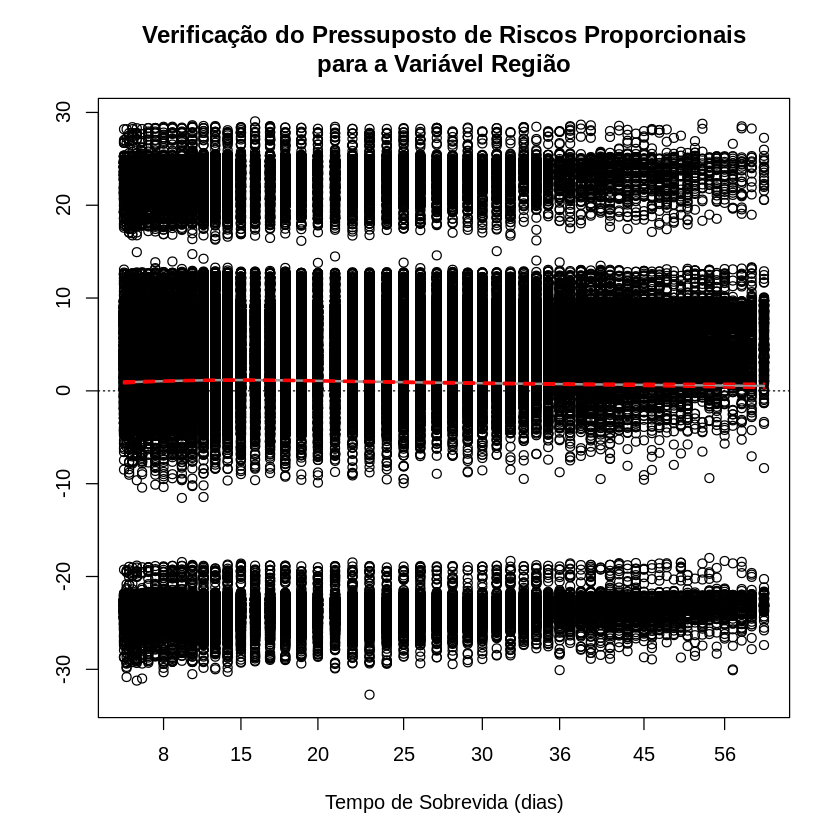

In [38]:
# Exemplo com mais customizações para um visual mais limpo
plot(teste_ph,
     var = "raca_cor",
     col = c("gray60", "red", "black"),  # Pontos em cinza para não poluir, linha vermelha
     lwd = 2,                           # Deixa a linha central mais grossa (espessura 2)
     pch = 1,                           # Bolinhas vazadas para os pontos
     xlab = "Tempo de Sobrevida (dias)",
     ylab = "Resíduo de Schoenfeld (β(t)) para Escolaridade",
     main = "Verificação do Pressuposto de Riscos Proporcionais\npara a Variável Região"
)

# Adiciona uma linha de referência no zero, se quiser
abline(h = 0, lty = 3, col = "black")

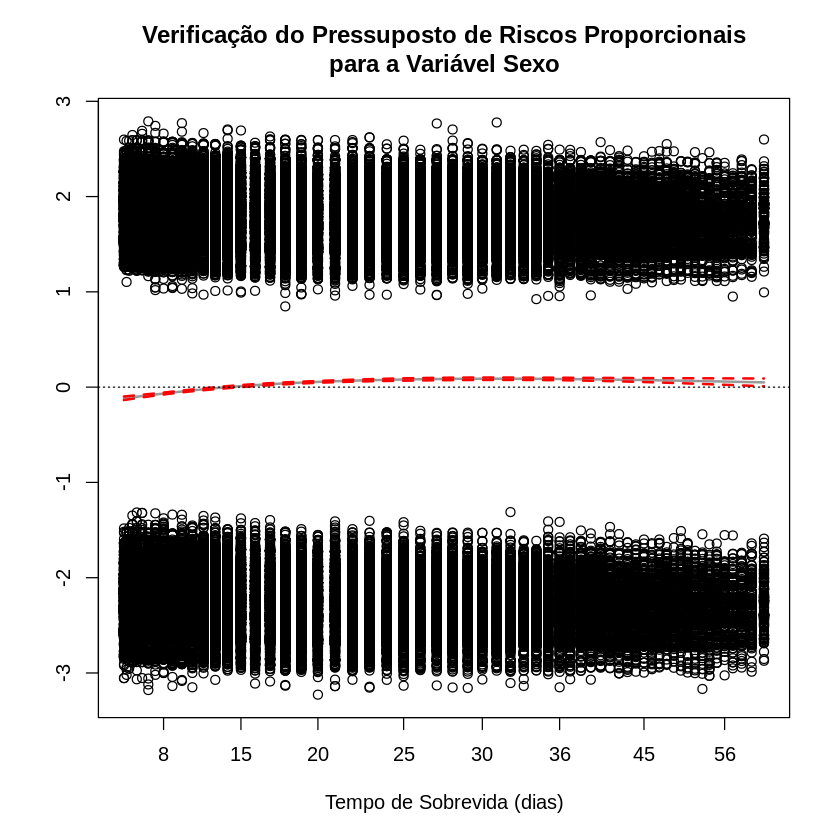

In [40]:
# Exemplo com mais customizações para um visual mais limpo
plot(teste_ph,
     var = "sexo",
     col = c("gray60", "red", "black"),  # Pontos em cinza para não poluir, linha vermelha
     lwd = 2,                           # Deixa a linha central mais grossa (espessura 2)
     pch = 1,                           # Bolinhas vazadas para os pontos
     xlab = "Tempo de Sobrevida (dias)",
     ylab = "Resíduo de Schoenfeld (β(t)) para Escolaridade",
     main = "Verificação do Pressuposto de Riscos Proporcionais\npara a Variável Sexo"
)

# Adiciona uma linha de referência no zero, se quiser
abline(h = 0, lty = 3, col = "black")

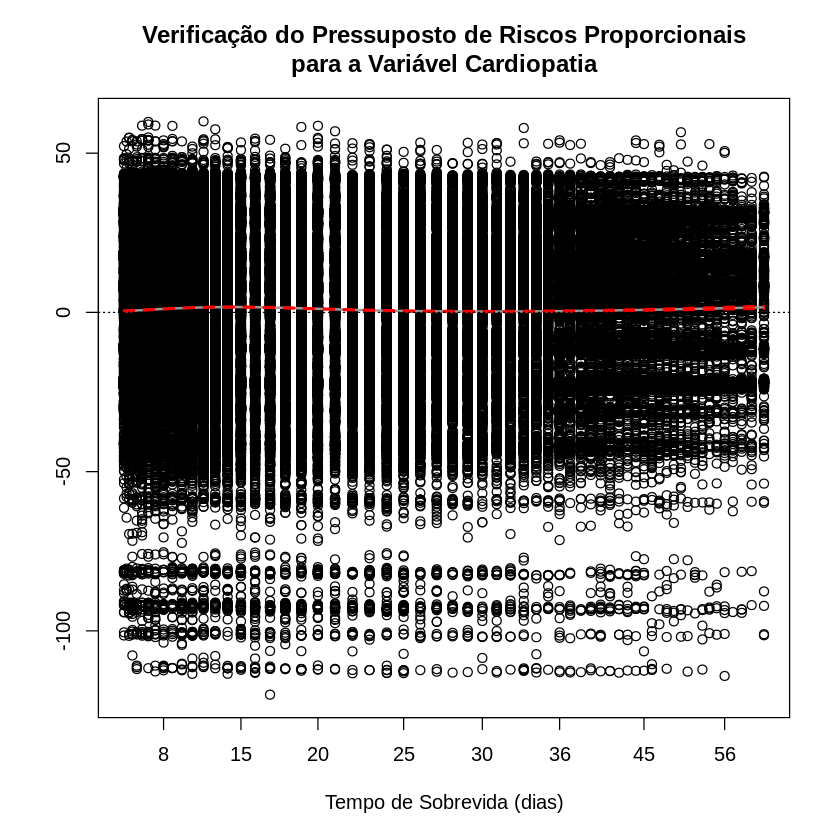

In [41]:
# Exemplo com mais customizações para um visual mais limpo
plot(teste_ph,
     var = "possui_cardiopatia",
     col = c("gray60", "red", "black"),  # Pontos em cinza para não poluir, linha vermelha
     lwd = 2,                           # Deixa a linha central mais grossa (espessura 2)
     pch = 1,                           # Bolinhas vazadas para os pontos
     xlab = "Tempo de Sobrevida (dias)",
     ylab = "Resíduo de Schoenfeld (β(t)) para Escolaridade",
     main = "Verificação do Pressuposto de Riscos Proporcionais\npara a Variável Cardiopatia"
)

# Adiciona uma linha de referência no zero, se quiser
abline(h = 0, lty = 3, col = "black")

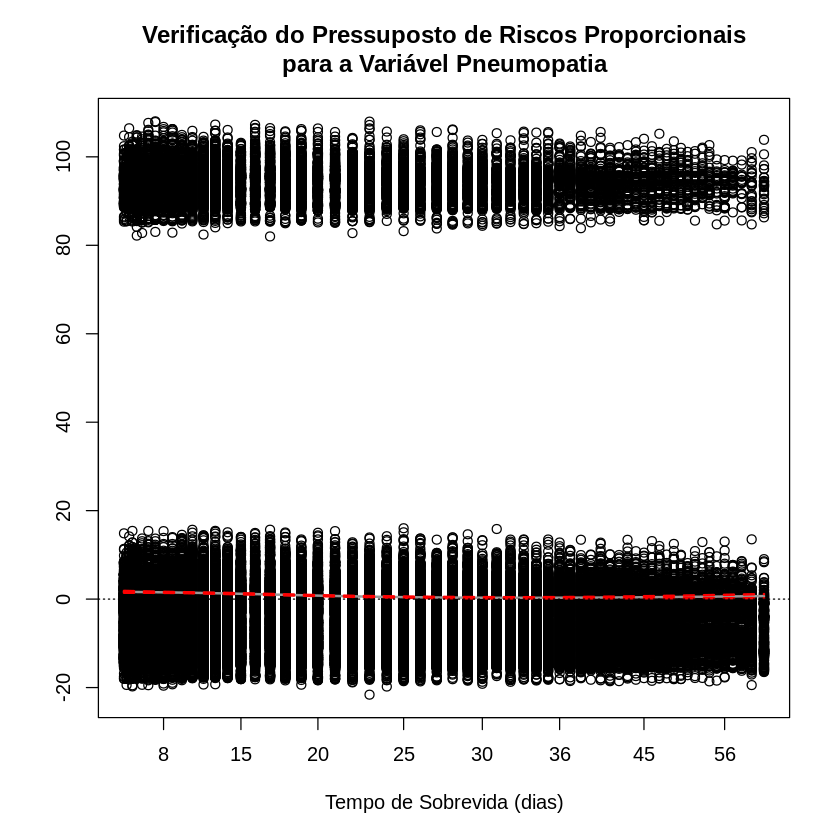

In [43]:
# Exemplo com mais customizações para um visual mais limpo
plot(teste_ph,
     var = "possui_pneumopatia",
     col = c("gray60", "red", "black"),  # Pontos em cinza para não poluir, linha vermelha
     lwd = 2,                           # Deixa a linha central mais grossa (espessura 2)
     pch = 1,                           # Bolinhas vazadas para os pontos
     xlab = "Tempo de Sobrevida (dias)",
     ylab = "Resíduo de Schoenfeld (β(t)) para Escolaridade",
     main = "Verificação do Pressuposto de Riscos Proporcionais\npara a Variável Pneumopatia"
)

# Adiciona uma linha de referência no zero, se quiser
abline(h = 0, lty = 3, col = "black")

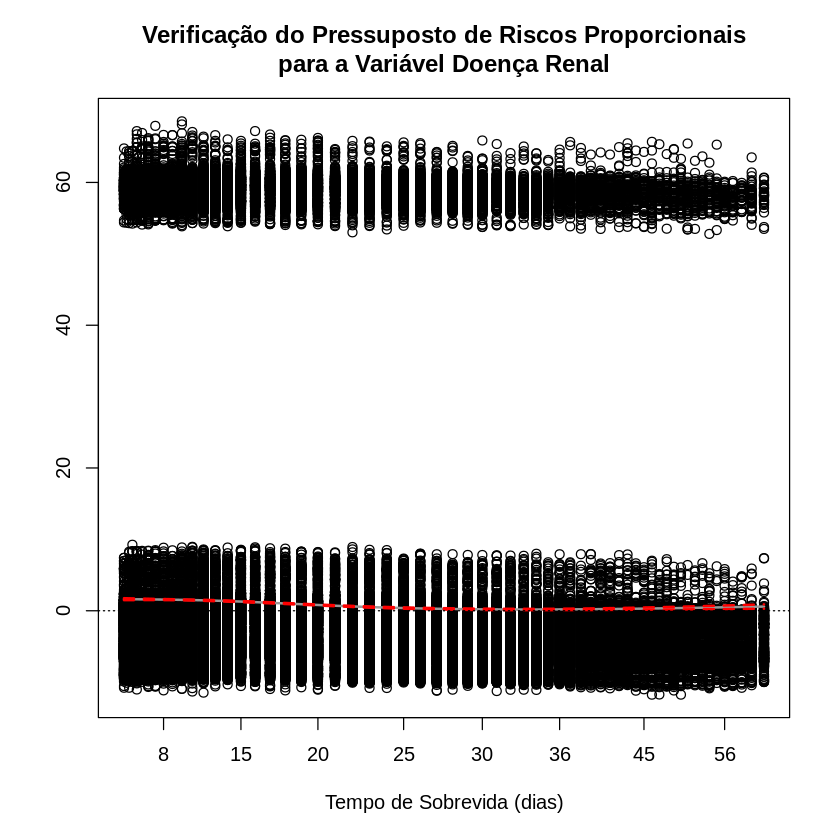

In [44]:
# Exemplo com mais customizações para um visual mais limpo
plot(teste_ph,
     var = "possui_doenca_renal",
     col = c("gray60", "red", "black"),  # Pontos em cinza para não poluir, linha vermelha
     lwd = 2,                           # Deixa a linha central mais grossa (espessura 2)
     pch = 1,                           # Bolinhas vazadas para os pontos
     xlab = "Tempo de Sobrevida (dias)",
     ylab = "Resíduo de Schoenfeld (β(t)) para Escolaridade",
     main = "Verificação do Pressuposto de Riscos Proporcionais\npara a Variável Doença Renal"
)

# Adiciona uma linha de referência no zero, se quiser
abline(h = 0, lty = 3, col = "black")

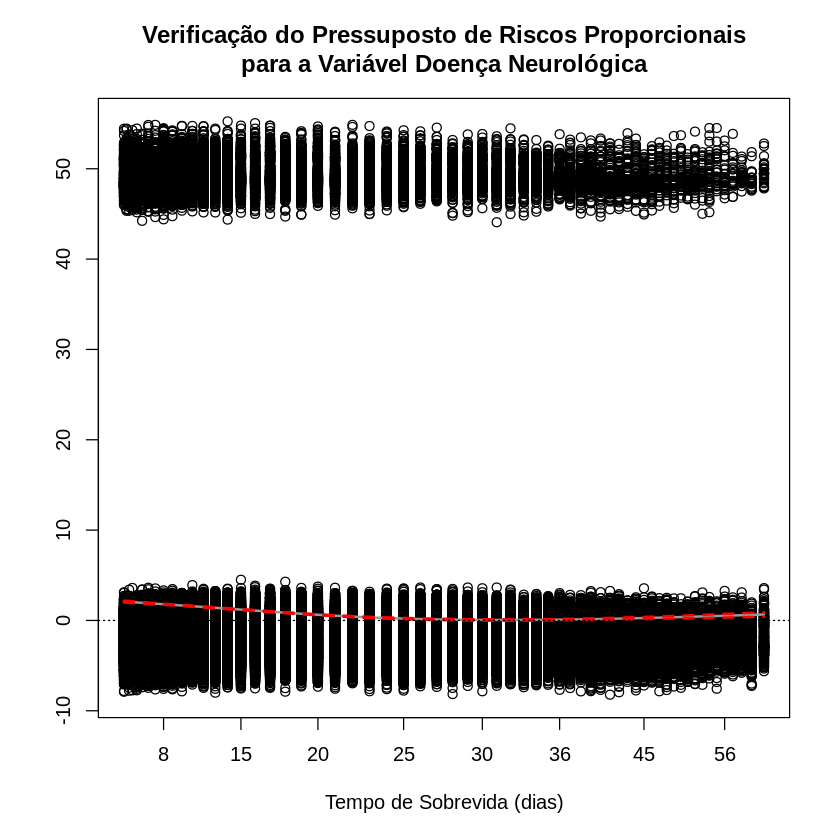

In [45]:
# Exemplo com mais customizações para um visual mais limpo
plot(teste_ph,
     var = "possui_doenca_neurologica",
     col = c("gray60", "red", "black"),  # Pontos em cinza para não poluir, linha vermelha
     lwd = 2,                           # Deixa a linha central mais grossa (espessura 2)
     pch = 1,                           # Bolinhas vazadas para os pontos
     xlab = "Tempo de Sobrevida (dias)",
     ylab = "Resíduo de Schoenfeld (β(t)) para Escolaridade",
     main = "Verificação do Pressuposto de Riscos Proporcionais\npara a Variável Doença Neurológica"
)

# Adiciona uma linha de referência no zero, se quiser
abline(h = 0, lty = 3, col = "black")

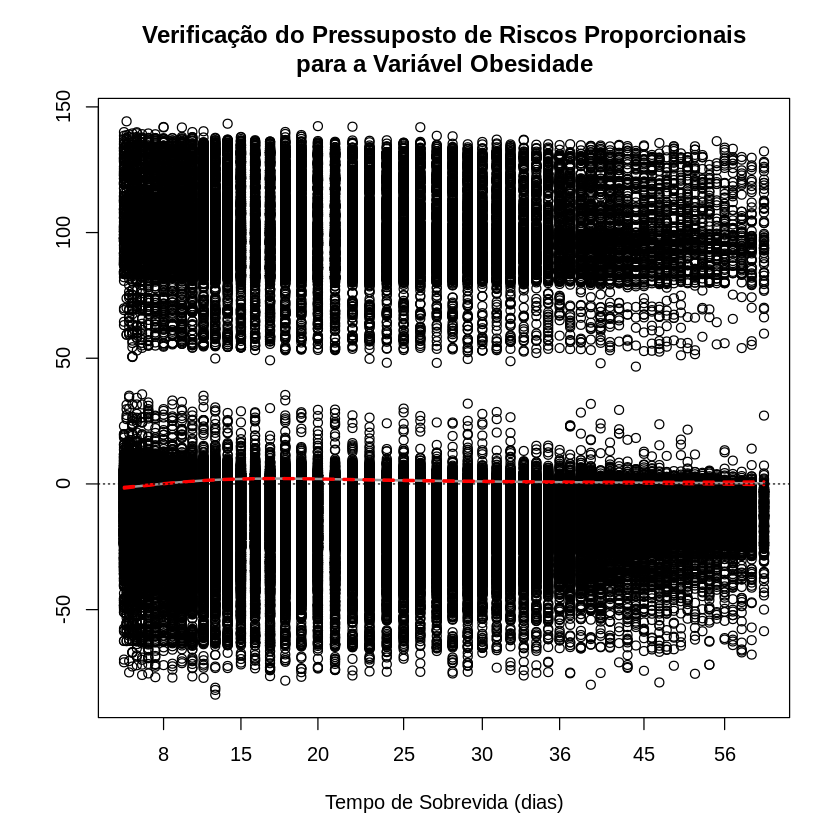

In [46]:
# Exemplo com mais customizações para um visual mais limpo
plot(teste_ph,
     var = "possui_obesidade",
     col = c("gray60", "red", "black"),  # Pontos em cinza para não poluir, linha vermelha
     lwd = 2,                           # Deixa a linha central mais grossa (espessura 2)
     pch = 1,                           # Bolinhas vazadas para os pontos
     xlab = "Tempo de Sobrevida (dias)",
     ylab = "Resíduo de Schoenfeld (β(t)) para Escolaridade",
     main = "Verificação do Pressuposto de Riscos Proporcionais\npara a Variável Obesidade"
)

# Adiciona uma linha de referência no zero, se quiser
abline(h = 0, lty = 3, col = "black")

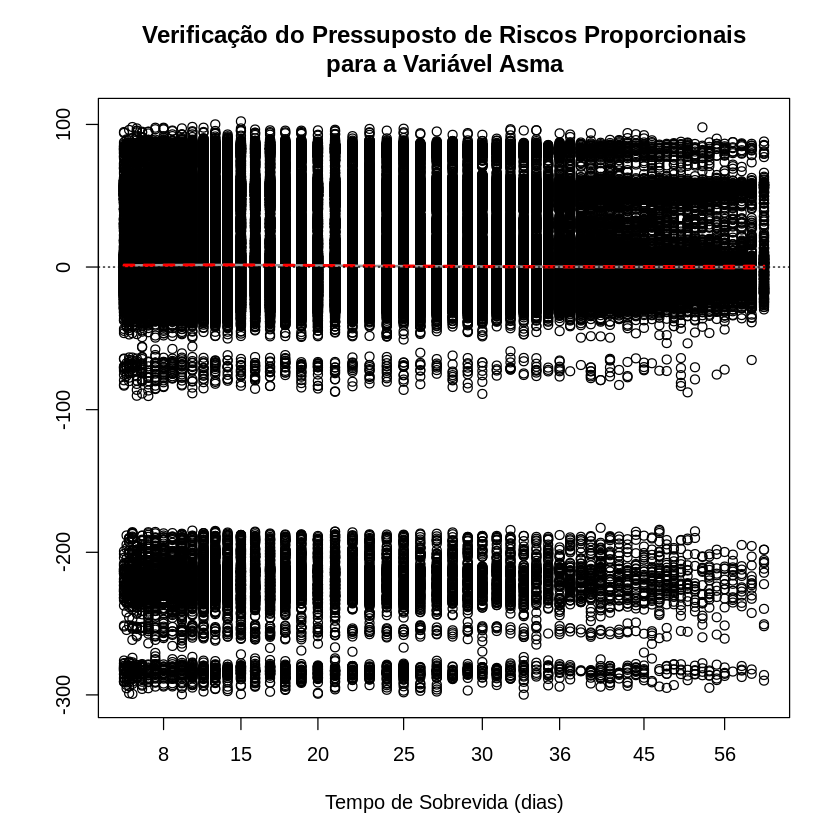

In [47]:
# Exemplo com mais customizações para um visual mais limpo
plot(teste_ph,
     var = "possui_asma",
     col = c("gray60", "red", "black"),  # Pontos em cinza para não poluir, linha vermelha
     lwd = 2,                           # Deixa a linha central mais grossa (espessura 2)
     pch = 1,                           # Bolinhas vazadas para os pontos
     xlab = "Tempo de Sobrevida (dias)",
     ylab = "Resíduo de Schoenfeld (β(t)) para Escolaridade",
     main = "Verificação do Pressuposto de Riscos Proporcionais\npara a Variável Asma"
)

# Adiciona uma linha de referência no zero, se quiser
abline(h = 0, lty = 3, col = "black")